Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 104MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 36.0MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 50.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.38MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[Epoch 0/50] [Batch 0/938] D_loss: 0.7158, G_loss: 0.6988
[Epoch 0/50] [Batch 200/938] D_loss: 0.5531, G_loss: 0.9756
[Epoch 0/50] [Batch 400/938] D_loss: 0.2775, G_loss: 2.4450
[Epoch 0/50] [Batch 600/938] D_loss: 0.3429, G_loss: 1.2322
[Epoch 0/50] [Batch 800/938] D_loss: 0.2557, G_loss: 2.9511
[Epoch 1/50] [Batch 0/938] D_loss: 0.2903, G_loss: 1.3386
[Epoch 1/50] [Batch 200/938] D_loss: 0.3871, G_loss: 5.5600
[Epoch 1/50] [Batch 400/938] D_loss: 0.3403, G_loss: 4.7022
[Epoch 1/50] [Batch 600/938] D_loss: 0.1164, G_loss: 3.6703
[Epoch 1/50] [Batch 800/938] D_loss: 0.1262, G_loss: 3.4077
[Epoch 2/50] [Batch 0/938] D_loss: 0.1610, G_loss: 4.0698
[Epoch 2/50] [Batch 200/938] D_loss: 0.1335, G_loss: 2.9015
[Epoch 2/50] [Batch 400/938] D_loss: 0.0550, G_loss: 6.6555
[Epoch 2/50] [Batch 600/938] D_loss: 0.1847, G_loss: 2.5013
[Epoch 2/50] [Batch 800/938] D_loss: 0.1601, G_loss: 4.0004
[Epoch 3/50] [Batch 0/938] D_lo

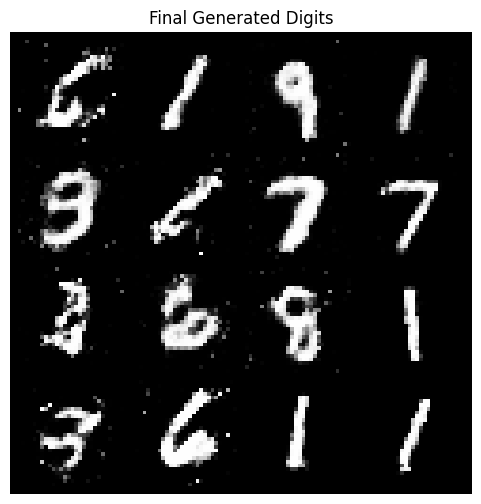

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
hidden_dim = 256
image_dim = 784  # 28x28 images
num_epochs = 50
batch_size = 64
lr = 0.0002
beta1 = 0.5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)

        # Ground truth labels
        real_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        d_optimizer.zero_grad()

        # Train with real images
        real_imgs = imgs.to(device)
        real_validity = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_validity, real_label)

        # Train with fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs.detach())
        d_fake_loss = adversarial_loss(fake_validity, fake_label)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        # -----------------
        #  Train Generator
        # -----------------
        g_optimizer.zero_grad()

        # Generate fake images and classify them
        fake_validity = discriminator(fake_imgs)
        g_loss = adversarial_loss(fake_validity, real_label)  # Trick discriminator

        g_loss.backward()
        g_optimizer.step()

        # Print progress
        if i % 200 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                  f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    # Save generated images every 10 epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            fake_imgs = generator(torch.randn(16, latent_dim).to(device))
            fake_imgs = fake_imgs.cpu()
            grid = make_grid(fake_imgs, nrow=4, normalize=True)

            plt.figure(figsize=(6, 6))
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis('off')
            plt.title(f'Generated Digits at Epoch {epoch}')
            plt.savefig(f'generated_digits_epoch_{epoch}.png')
            plt.close()

# Save final generator model
torch.save(generator.state_dict(), 'generator.pth')

# Generate and display final samples
with torch.no_grad():
    final_samples = generator(torch.randn(16, latent_dim).to(device))
    final_samples = final_samples.cpu()
    grid = make_grid(final_samples, nrow=4, normalize=True)

    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.title('Final Generated Digits')
    plt.savefig('final_generated_digits.png')
    plt.show()